# Read in the data

In [34]:
import sys

!$sys.executable -m pip install cufflinks

     |████████████████████████████████| 81 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 4.3 MB/s eta 0:00:01
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67920 sha256=de932f40ef41bb3ddf893bf0d95e3d2329841e95deeab78f21d88a8b6eb2eb26
  Stored in directory: /home/radu/.cache/pip/wheels/6b/76/62/6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866
Successfully built cufflinks


In [29]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pandas as pd
import numpy
import re
%matplotlib inline

In [35]:
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf

In [36]:
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
sns.set_style("darkgrid")

Text(0, 0.5, 'Value')

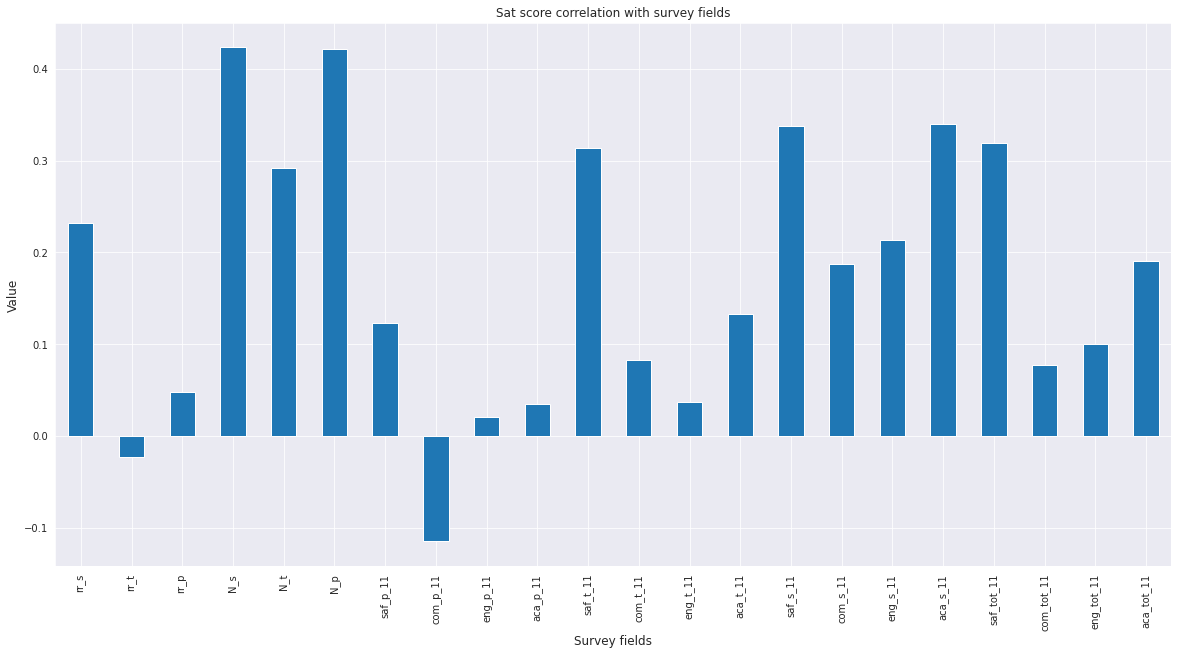

In [13]:
plt.figure(figsize=(20, 10))
ax = correlations[survey_fields].plot.bar()
ax.set_title("Sat score correlation with survey fields")
ax.set_xlabel("Survey fields",fontsize=12)
ax.set_ylabel("Value",fontsize=12)

As is shown in the previous **Sat score correlation with survey fields** plot. There are high correlations between **sat_score** and **N_s and N_p**. It makes sense, since these columns are correlated with the **total_enrollment** column.

Follwed by the safety columns **saf_t_11 and saf_s_11** which are high correlated with the **sat_score** column to.

Also, another interesting correlation but no with the same importance as the previous ones is the **sat_score** correlation with **rr_s** colum. Which shows the student response rate.

# Exploring safety scores

In [40]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='saf_s_11',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["saf_s_11"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='Safety score 11',
    yTitle='Satisfaction score avg',
    title='Exploring safety score'
)

After seeing the **Exploring safety score** we can conclude that there is a correlation between the **sat_score** and **sad_s_11**.

The majority of the schools have an average **saf_s_11** between **5.5 and 7.5** and an average **sat_score** over **1000** and **1400**.

Also, we can see that there is a high correlation between schools with an extremely high SAT score and **sad_s_11** score.

To sum up, there is a correlation between these indicators but it isn't so strong at may seem at first look.

## Mapping safety scores

In [15]:
safety_avg_by_district = combined.groupby('school_dist').agg(numpy.mean)
safety_avg_by_district

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,139.041709,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,97.597416,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,129.765099,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,100.118588,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240


In [16]:
safety_avg_by_district.reset_index(inplace=True)

In [17]:
by_district = combined.groupby("school_dist").mean().reset_index()

In [18]:
import folium
import branca.colormap as cm

In [27]:
#set a simple baselayer and zoom-in on NY
school_map = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=10,
                        tiles='CartoDB positron')

# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "Safety average by district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

# select column names of the viz parameters
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = safety_avg_by_district[color_parameter].min()
end_col_val = safety_avg_by_district[color_parameter].max()
start_col_hex = "#d01c8b" # used https://colorbrewer2.org/ 
end_col_hex = "#4dac26"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     #"white",
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety average by district"

# create a circle for each school district
for index, row in safety_avg_by_district.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)

# add a legend
school_map.add_child(colormap)
    
# display the map
school_map

It looks like:
<li> High safety scires: Upper Manhattan and parts of Queens.</li>
<li> Low safety scores: Brooklyn.</li>

# Racial differences in SAT preformance

In [25]:
race_percentage_indicators = [
    'white_per', 
    'asian_per', 
    'black_per', 
    'hispanic_per'
]

Text(0, 0.5, 'Correlation')

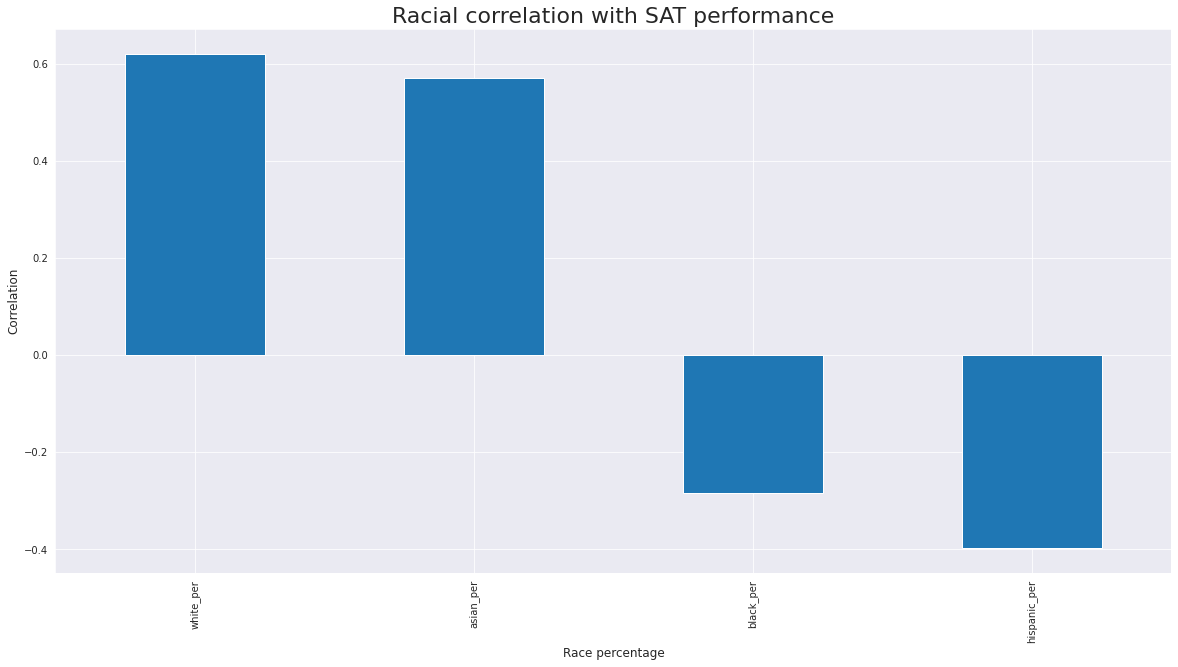

In [26]:
plt.figure(figsize=(20, 10))
ax = correlations[race_percentage_indicators].plot.bar()
ax.set_title("Racial correlation with SAT performance", fontsize=22)
ax.set_xlabel("Race percentage",fontsize=12)
ax.set_ylabel("Correlation",fontsize=12)

From the **Racial correlation with SAT performance** it seems like a higher percentage of **white** or **asian** students correlates positively with the **SAT score** averages. 

On the other hand, seems looks like a higher percentage of **black** and **hispanic** students correlates negatively with  the **SAT score** averages. 

On this point we have two questions are this correlations due a lack of funding for schools in certain areas, with higher percentage of **black** and **hispanic** students or simply **white** and **asian** students are more fitting better in the current educational system.

## Hispanic per vs Sat score

In [37]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='hispanic_per',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["hispanic_per"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='Hispanic %',
    yTitle='Satisfaction score avg',
    title='Hispanic per vs Sat score'
)

Text(0, 0.5, 'Satisfaction score avg')

<Figure size 1440x720 with 0 Axes>

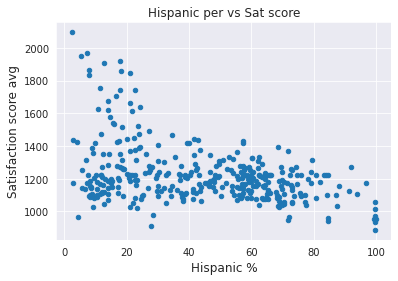

In [50]:
plt.figure(figsize=(20, 10))
ax = combined.plot.scatter('hispanic_per', 'sat_score')
ax.set_title("Hispanic per vs Sat score")
ax.set_xlabel("Hispanic %",fontsize=12)
ax.set_ylabel("Satisfaction score avg",fontsize=12)

It tseems that there isn't a strong correlation between **Hispanic per and Sat score** but the previous plot shows clearly that independently of the percentage of the **hispanic** students, the  **Sat score** is between 1000 and 1400, as we have seen previously.

What the previous scatter plot shows is that the schools with a percentage of **hispanic** students between 0% and 20% are the ones with a higher average **Satisfaction score**.

On the other hand the extreme cases of the schools with a a hispanic students percentage of **100%** are the ones with lower **SAT score**. This may be due a lack of capital on this schools for **hispanic** students.

In [28]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Schools info
<a href="https://en.wikipedia.org/wiki/List_of_high_schools_in_New_York_City" > Schools info.</a> After reading the descriptions of the listed schools, they appear to primarily be geared towards recent immigrants to the US. These schools students are starting the inclusion program by  learning English, which would explain the lower SAT scores.

In [29]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above are specialized on science and technology, that generally receive extra founding to foment investigation and research. They only admin students after passing an entrance exam. 

There is no explanation why this percentage of hispanic students is so low, but the admision process may explain why the SAT score of this students is higher.

# Gender differences in SAT scores

Text(0, 0.5, 'Correlation')

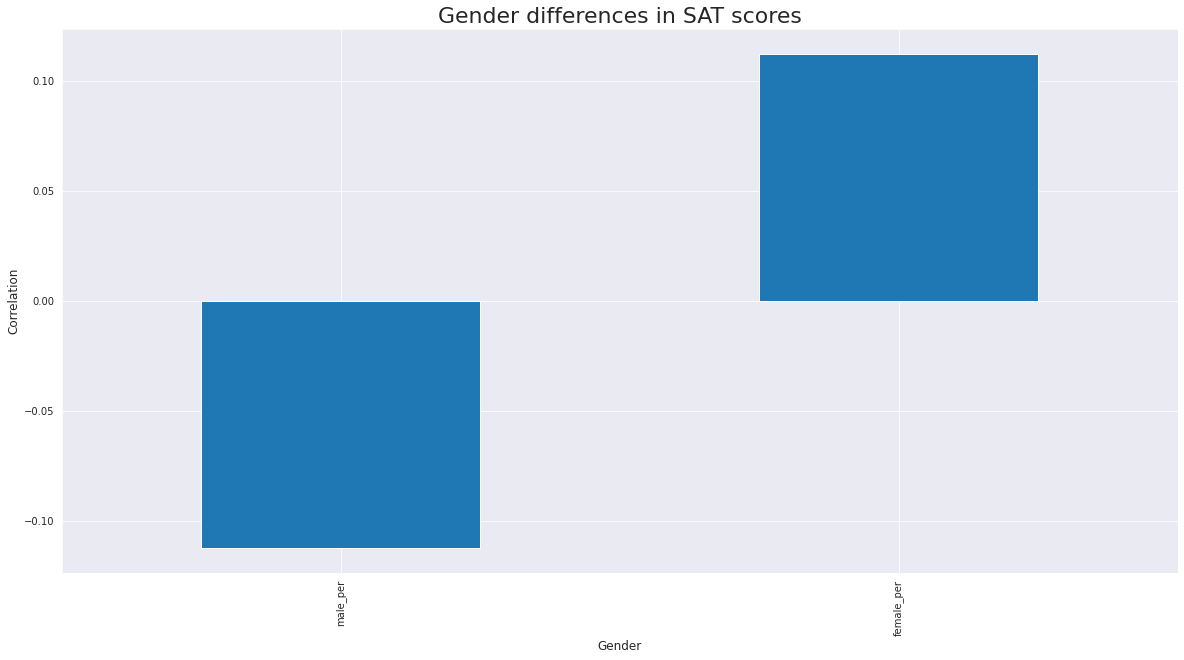

In [30]:
plt.figure(figsize=(20, 10))
ax = correlations[['male_per', 'female_per']].plot.bar()
ax.set_title("Gender differences in SAT scores", fontsize=22)
ax.set_xlabel("Gender",fontsize=12)
ax.set_ylabel("Correlation",fontsize=12)

In the **Gender differences in SAT scores**, we can see that **females** have a high positive correlation with **SAT scores** and **males** a high negative correlation.

## Female gender and SAT score

In [41]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='female_per',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["female_per"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='Female %',
    yTitle='Satisfaction score avg',
    title='Female per vs Sat score'
)

Text(0, 0.5, 'Satisfaction score avg')

<Figure size 1440x1440 with 0 Axes>

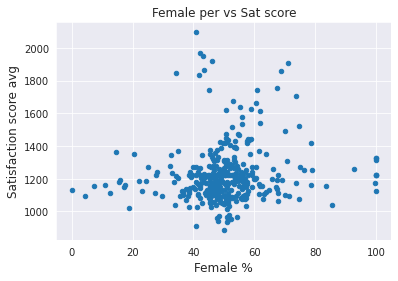

In [48]:
plt.figure(figsize=(20, 20))
ax = combined.plot.scatter('female_per', 'sat_score')
ax.set_title("Female per vs Sat score")
ax.set_xlabel("Female %",fontsize=12)
ax.set_ylabel("Satisfaction score avg",fontsize=12)

From the scatter above we can see a strong correlation between **Satisfaction Score** and **Female percentage**. But, there is a cluster of schools with a female percentage between 55% and 65% with a **high** SAT score.

In [32]:
combined[(
    combined["female_per"] > 60) & 
    (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The shwon cluster in the scatter plot which schools are listed aboved, are formed by schools with **high academic standards** and specialized on **arts**. <a href="https://en.wikipedia.org/wiki/Bard_High_School_Early_College" > School info example.</a> 

# AP Exam Scores and SAT Scores

In the U.S., high school students take <a href="https://en.wikipedia.org/wiki/Advanced_Placement_exams" > Advanced Placement (AP).</a> exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [45]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

## AP per and SAT score

In [46]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='ap_per',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["ap_per"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='AP %',
    yTitle='Satisfaction score avg',
    title='AP per vs Sat score'
)

Text(0, 0.5, 'Satisfaction score avg')

<Figure size 1440x720 with 0 Axes>

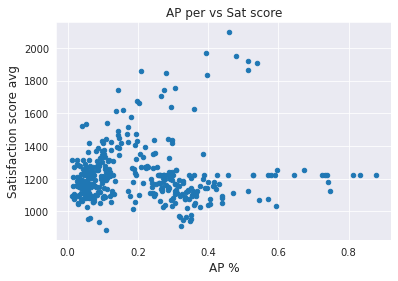

In [47]:
plt.figure(figsize=(20, 10))
ax = combined.plot.scatter('ap_per', 'sat_score')
ax.set_title("AP per vs Sat score")
ax.set_xlabel("AP %",fontsize=12)
ax.set_ylabel("Satisfaction score avg",fontsize=12)


It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Average Class Size and SAT score 

In [52]:
combined[['AVERAGE CLASS SIZE', 'sat_score']]

,AVERAGE CLASS SIZE,sat_score
0,22.564286,1122.0
1,22.231250,1172.0
2,21.200000,1149.0
3,23.571429,1207.0
4,25.510526,1621.0
...,...,...
358,22.958824,1154.0
359,22.760000,1035.0
360,23.900000,1060.0
361,17.793750,1315.0


In [54]:
warnings.filterwarnings("ignore",category=FutureWarning)
combined.iplot(
    x='AVERAGE CLASS SIZE',
    y='sat_score',
    categories='boro',
    text="SCHOOL NAME",
    vline= {"x":combined["AVERAGE CLASS SIZE"].mean(),
            "color":"#000000",
            "dash": "dash"
           },
    hline={"y":combined["sat_score"].mean(),
           "color":"#000000",
           "dash": "dash"
          },
    xTitle='AVG class size',
    yTitle='Satisfaction score avg',
    title='AVG class size vs Sat score'
)

From the previous scatter plot we can extract that there is a correlation and in general schools with higher average in terms of class size seem to have also a higher average in SAT scores.

In [60]:
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,0.305756
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,0.098985
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,0.031773
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,0.351577
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,0.158091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,32K545,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,88,384.0,409.0,361.0,1154.0,EBC-HS FOR PUB SERVICE (BUSH),47.000000,64.000000,...,0,0,0.0,0.0,0.0,"1155 Dekalb Avenue\nBrooklyn, NY 11221\n(40.69...",40.694482,-73.929154,32,0.077558
359,32K549,BUSHWICK SCHOOL FOR SOCIAL JUSTICE,75,348.0,353.0,334.0,1035.0,0,129.028846,197.038462,...,Then to New York City residents,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32,0.297301
360,32K552,ACADEMY OF URBAN PLANNING,67,342.0,364.0,354.0,1060.0,Academy of Urban Planning,76.000000,100.000000,...,0,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32,0.190955
361,32K554,ALL CITY LEADERSHIP SECONDARY SCHOOL,39,428.0,465.0,422.0,1315.0,All City Leadership Secondary School,7.000000,8.000000,...,Then to Brooklyn students or residents,Then to New York City residents,0.0,0.0,0.0,"321 Palmetto Street\nBrooklyn, NY 11237\n(40.6...",40.697408,-73.913153,32,0.026616
